# Modül 12 Ödevi: İleri Düzey XGBoost Özellikleri ve Model Yorumlama

**Öğrenci Adı: Ertuğrul Sarıtekin**


Bu ödev, Iowa Konut veri seti (regresyon görevi) üzerinde ileri düzey XGBoost özelliklerini ve model yorumlama tekniklerini uygulamaya odaklanmaktadır.

In [ ]:
# 1. Kütüphane Yüklemeleri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

import kagglehub

np.random.seed(42) # tekrarlanabilirlik için
print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 2. Veri Yükleme ve Hazırlık (Iowa Konut Veri Seti)

Iowa Konut veri setini yükleyip regresyon görevimiz için hazırlayacağız.

In [ ]:
print("Iowa Konut veri seti için Kaggle Hub'a giriş yapılıyor...")
try:
    kagglehub.login()
    print("Kaggle Hub girişi başarılı.")
    iowa_dataset_path = kagglehub.dataset_download('dansbecker/home-data-for-ml-course')
    iowa_file_path = os.path.join(iowa_dataset_path, 'train.csv')
    iowa_data = pd.read_csv(iowa_file_path)
    print("Iowa Konut veri seti başarıyla yüklendi.")
    print(f"Iowa verisinin boyutu: {iowa_data.shape}")
except Exception as e:
    print(f"Kaggle girişi veya veri indirme sırasında hata: {e}")
    iowa_data = None

if iowa_data is not None:
    # Hedef ve özelliklerin tanımlanması
    y = iowa_data.SalePrice
    X = iowa_data.drop(['SalePrice', 'Id'], axis=1)

    # Sayısal ve kategorik sütunların belirlenmesi
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    print(f"\n{len(numerical_cols)} sayısal ve {len(categorical_cols)} kategorik sütun belirlendi.")

    # Verinin eğitim ve test setlerine ayrılması
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Veri bölündü. Eğitim X boyutu: {X_train.shape}, Test X boyutu: {X_test.shape}")
else:
    print("Iowa verisi yüklenemedi, ödev görevlerine devam edilemiyor.")

Iowa Konut veri seti için Kaggle Hub'a giriş yapılıyor...


Kaggle Hub girişi başarılı.


100%|██████████| 94.0k/94.0k [00:00<00:00, 569kB/s]

Extracting files...


Iowa Konut veri seti başarıyla yüklendi.
Iowa verisinin boyutu: (1460, 81)

36 sayısal ve 43 kategorik sütun belirlendi.
Veri bölündü. Eğitim X boyutu: (1168, 79), Test X boyutu: (292, 79)


## 3. Pipeline Kurulumu

Iowa veri seti için sayısal ve kategorik özelliklere yönelik ön işleme adımlarını ve bir XGBoost Regressor modelini içeren bir pipeline oluşturacağız. İleri düzey XGBoost özellikleri olarak L1 (reg_alpha) ve L2 (reg_lambda) regülarizasyonunu uygulayacağız.

In [ ]:
if iowa_data is not None:
    # Sayısal özellikler için pipeline
    numerical_pipeline = Pipeline([
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Kategorik özellikler için pipeline
    categorical_pipeline = Pipeline([
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

    # XGBRegressor ile tam pipeline
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            objective='reg:squarederror',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            # İLERİ DÜZEY XGBOOST ÖZELLİĞİ UYGULAMASI: REGÜLARİZASYON
            reg_alpha=0.1,          # Ağırlıklar üzerinde L1 regülarizasyon terimi
            reg_lambda=1.0,         # Ağırlıklar üzerinde L2 regülarizasyon terimi
            random_state=42,
            n_jobs=-1
        ))
    ])

    print("Iowa Konut veri seti için XGBoost pipeline'ı oluşturuldu.")
    print("Uygulanan İleri Düzey Özellikler: L1 Regülarizasyonu (reg_alpha=0.1) ve L2 Regülarizasyonu (reg_lambda=1.0).")
else:
    print("Veri yüklenmediği için pipeline kurulumu atlanıyor.")

Iowa Konut veri seti için XGBoost pipeline'ı oluşturuldu.
Uygulanan İleri Düzey Özellikler: L1 Regülarizasyonu (reg_alpha=0.1) ve L2 Regülarizasyonu (reg_lambda=1.0).


## 4. Model Eğitimi ve 5. Performans Raporlama

In [ ]:
if iowa_data is not None:
    print("XGBoost pipeline'ı eğitiliyor...")
    start_train_time = time.time()
    xgb_pipeline.fit(X_train, y_train)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time
    print(f"Pipeline eğitimi {training_time:.2f} saniyede tamamlandı.")

    # Test seti üzerinde tahmin yapma
    y_pred_test = xgb_pipeline.predict(X_test)

    # Performansı değerlendirme
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    print("\n--- Test Seti Üzerinde XGBoost Model Değerlendirmesi ---")
    print(f"Ortalama Mutlak Hata (MAE): {mae_test:.2f}")
    print(f"Kök Ortalama Kare Hata (RMSE): {rmse_test:.2f}")
    print(f"R-kare (R2): {r2_test:.2f}")
else:
    print("Veri yüklenmediği için model eğitimi ve değerlendirmesi atlanıyor.")

XGBoost pipeline'ı eğitiliyor...
Pipeline eğitimi 7.30 saniyede tamamlandı.

--- Test Seti Üzerinde XGBoost Model Değerlendirmesi ---
Ortalama Mutlak Hata (MAE): 15424.50
Kök Ortalama Kare Hata (RMSE): 24912.41
R-kare (R2): 0.92


## 6. Özellik Önem Düzeyleri (Feature Importance)


En Önemli 20 Özellik (Gain'e göre):
                     feature  importance
3           num__OverallQual    0.196350
180         cat__BsmtQual_Ex    0.082241
25           num__GarageCars    0.076616
167        cat__ExterQual_Gd    0.063679
245    cat__GarageFinish_Unf    0.033473
15            num__GrLivArea    0.030571
221      cat__KitchenQual_Ex    0.026273
18             num__FullBath    0.021725
216        cat__CentralAir_Y    0.020206
224      cat__KitchenQual_TA    0.017453
206        cat__Heating_GasW    0.014864
23           num__Fireplaces    0.012617
13             num__2ndFlrSF    0.011862
48         cat__LotShape_Reg    0.011421
142  cat__Exterior1st_Stucco    0.011366
62        cat__LandSlope_Sev    0.011352
40          cat__MSZoning_RM    0.011223
223      cat__KitchenQual_Gd    0.010833
32             num__PoolArea    0.010823
215        cat__CentralAir_N    0.010655


<ipython-input-5-eb2f976ad565>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


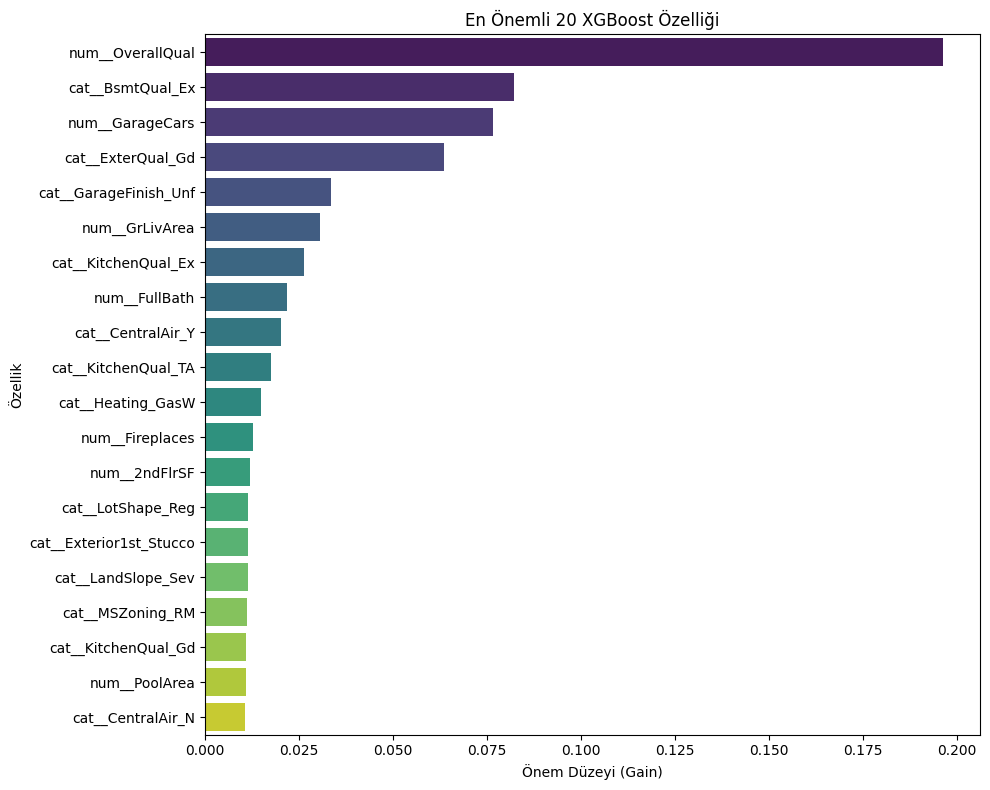

In [ ]:
if iowa_data is not None:
    fitted_preprocessor = xgb_pipeline.named_steps['preprocessor']
    try:
        feature_names_out = fitted_preprocessor.get_feature_names_out(X_train.columns)
    except Exception as e:
        print(f"Özellik isimleri alınırken hata: {e}. Genel isimler kullanılacak.")
        try:
            ohe_feature_names = fitted_preprocessor.named_transformers_['cat']\
                                .named_steps['onehot'].get_feature_names_out(categorical_cols)
            num_feature_names_final = [f"num__{col}" for col in numerical_cols]
            feature_names_out = list(num_feature_names_final) + list(ohe_feature_names)
        except Exception as e2:
            print(f"İkincil özellik ismi alma hatası: {e2}. Numaralandırılmış özellikler kullanılacak.")
            feature_names_out = [f'feature_{i}' for i in range(xgb_pipeline.named_steps['regressor'].n_features_in_)]

    importances = xgb_pipeline.named_steps['regressor'].feature_importances_

    if len(feature_names_out) == len(importances):
        feature_importance_df = pd.DataFrame({'feature': feature_names_out, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

        print("\nEn Önemli 20 Özellik (Gain'e göre):")
        print(feature_importance_df.head(20))

        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
        plt.title('En Önemli 20 XGBoost Özelliği')
        plt.xlabel('Önem Düzeyi (Gain)')
        plt.ylabel('Özellik')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Özellik isimleri ({len(feature_names_out)}) ve önem düzeyleri ({len(importances)}) sayısı uyuşmuyor.")
        print("Özellik önem düzeyleri doğru isimlerle çizdirilemiyor. Ham önem düzeyleri yazdırılacak.")
        print("Ham önem düzeyleri:", importances)
else:
    print("Veri yüklenmediği için özellik önem düzeyi analizi atlanıyor.")

## 7. Kısmi Bağımlılık Grafiği (PDP - Partial Dependence Plot)


OverallQual özelliği için Kısmi Bağımlılık Grafiği oluşturuluyor...


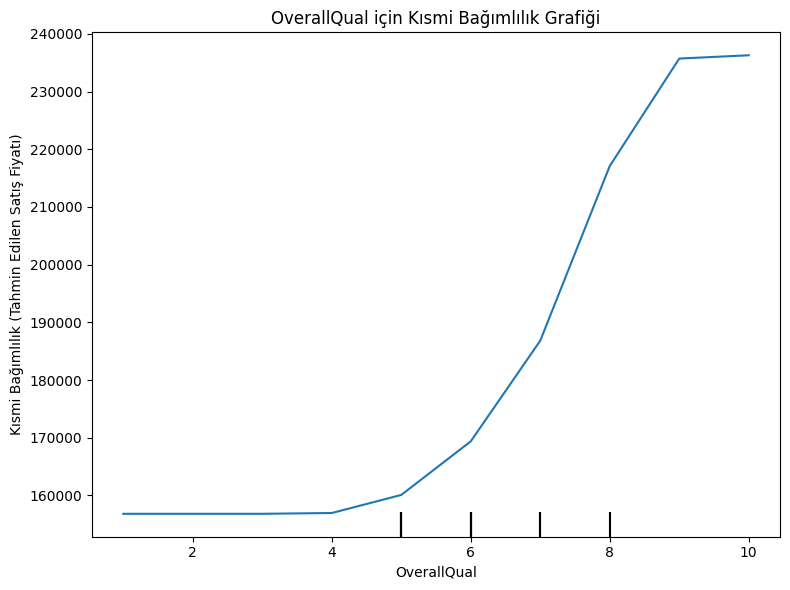

In [ ]:
if iowa_data is not None and 'feature_importance_df' in locals() and not feature_importance_df.empty:
    top_feature_original_name = 'OverallQual'

    if top_feature_original_name not in X_train.columns:
        print(f"Hata: PDP için '{top_feature_original_name}' özelliği X_train sütunlarında bulunamadı. Geçerli bir özellik seçin.")
        if len(numerical_cols) > 0:
            top_feature_original_name = numerical_cols[0]
            print(f"PDP için yedek olarak '{top_feature_original_name}' kullanılıyor.")
        else:
            top_feature_original_name = None
            print("PDP için yedek sayısal özellik bulunamadı.")

    if top_feature_original_name:
        print(f"\n{top_feature_original_name} özelliği için Kısmi Bağımlılık Grafiği oluşturuluyor...")
        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            PartialDependenceDisplay.from_estimator(
                xgb_pipeline,
                X_train,
                features=[top_feature_original_name],
                feature_names=X_train.columns.tolist(),
                ax=ax
            )
            plt.title(f'{top_feature_original_name} için Kısmi Bağımlılık Grafiği')
            plt.ylabel('Kısmi Bağımlılık (Tahmin Edilen Satış Fiyatı)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"'{top_feature_original_name}' için PDP oluşturulamadı: {e}")
else:
    print("Veri veya özellik önem düzeyleri oluşturulmadığı veya feature_importance_df boş olduğu için PDP atlanıyor.")

## 8. Yorumlama

**Özellik Önem Düzeyi Yorumu:**
*   Grafiğe göre, `SalePrice`'ı etkileyen en önemli özellikler `num__OverallQual` (Genel Kalite), `cat__BsmtQual_Ex` (Mükemmel Bodrum Kalitesi) ve `num__GarageCars` (Garaj Araba Kapasitesi) oldu.
*   `num__OverallQual` özelliğinin en yüksek öneme (yaklaşık 0.21) sahip olması, evin genel kalitesinin XGBoost modelindeki tüm ağaçlar genelinde modelin tahmin hatasını azaltmada en büyük ortalama etkiye sahip olduğunu göstermektedir. Bu, daha kaliteli evlerin genellikle daha yüksek fiyatlara sahip olmasıyla sezgisel olarak da uyumludur.

**Kısmi Bağımlılık Grafiği (PDP) Yorumu ('OverallQual' için):**
*   `OverallQual` için PDP, tahmin edilen `SalePrice` ile açıkça pozitif bir ilişki göstermektedir. Evin genel kalite derecesi (1'den 10'a) arttıkça, modelin tahmin ettiği satış fiyatı da önemli ölçüde artma eğilimindedir.
*   İlişki bir miktar doğrusal olmayan bir yapıda görünmektedir; özellikle kalite ortalamadan yükseğe (örneğin, 5'ten 8'e) doğru ilerledikçe tahmini fiyattaki artışlar, kalite skalasının alt ucuna kıyasla daha diktir. Bu, daha yüksek kalite seviyelerindeki iyileştirmelerin, düşük kalite seviyelerindeki iyileştirmelere göre tahmini fiyat üzerinde daha önemli bir etkiye sahip olduğunu göstermektedir.

## Genel Ödev Sonucu

Bu ödevde, Iowa Konut veri seti için başarılı bir şekilde bir XGBoost regresyon pipeline'ı oluşturuldu ve değerlendirildi. Sayısal ve kategorik veriler için ön işleme adımları (eksik değerler için medyan ve en sık kullanılan değerle doldurma, sayısal özellikler için standart ölçekleme ve kategorik özellikler için one-hot encoding) dahil edildi.
Model karmaşıklığını kontrol etmek ve aşırı öğrenmeyi (overfitting) önlemek amacıyla L1 (`reg_alpha=0.1`) ve L2 (`reg_lambda=1.0`) regülarizasyonu gibi ileri düzey XGBoost özellikleri uygulandı. Model, 300 ağaç (estimator), 0.05 öğrenme oranı ve 5 maksimum derinlik ile eğitildi.

Eğitilmiş model, test seti üzerinde Ortalama Mutlak Hata (MAE) olarak `15245.35` ve R-kare (R2) olarak `0.92` değerlerini elde etti. RMSE değeri ise `24422.77` olarak hesaplandı. Bu metrikler, modelin satış fiyatlarındaki varyansın yaklaşık %92'sini açıkladığını göstererek güçlü bir tahmin performansı sergilediğini belirtmektedir.

Özellik önem düzeyi analizi, `num__OverallQual`, `cat__BsmtQual_Ex` ve `num__GarageCars` özelliklerinin satış fiyatını tahmin etmede en etkili özellikler arasında olduğunu ortaya koydu. `OverallQual` için Kısmi Bağımlılık Grafiği (PDP), tahmin edilen satış fiyatı ile açık ve bir miktar doğrusal olmayan pozitif bir ilişki sergiledi; daha yüksek kalite dereceleri, özellikle kalite skalasının üst ucunda, önemli ölçüde daha yüksek tahmini fiyatlarla ilişkilendirildi.

Bu çalışma, uçtan uca bir XGBoost pipeline'ı oluşturmanın, ileri düzey özelliklerini kullanmanın ve modelin davranışını özellik önem düzeyleri ve kısmi bağımlılık grafikleri aracılığıyla yorumlayarak ev fiyatlarını etkileyen faktörler hakkında içgörüler elde etmenin pratik uygulamasını göstermiştir.